<a href="https://colab.research.google.com/github/chelynl/Machine_Learning/blob/main/ML_Method_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Data
from google.colab import files 
import pandas as pd 
import io 

# Data Wrangling and Plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gradient Boost
import xgboost as xgb # xgboost
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Accuracy Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, classification_report, confusion_matrix, plot_confusion_matrix

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
uploaded = files.upload()

Saving reduced_test.csv to reduced_test.csv
Saving reduced_train.csv to reduced_train.csv
Saving reduced_train_valid.csv to reduced_train_valid.csv
Saving reduced_valid.csv to reduced_valid.csv


In [ ]:
train_df = pd.read_csv(io.BytesIO(uploaded['reduced_train.csv'])) 
valid_df = pd.read_csv(io.BytesIO(uploaded['reduced_valid.csv']))
train_valid_df = pd.read_csv(io.BytesIO(uploaded['reduced_train_valid.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded['reduced_test.csv']))

In [ ]:
# Get inputs and outputs as separate dfs on training data
X_train = train_df.drop(['binary.target2'], axis=1)
y_train = train_df['binary.target2']

# Repeat for validation data
X_valid = valid_df.drop(['binary.target2'], axis=1)
y_valid = valid_df['binary.target2']

# Convert input and output dfs to arrays for sklearn
X_train = np.array(X_train)
y_train = np.ravel(np.array(y_train))

# Repeat for validation data
X_valid = np.array(X_valid)
y_valid = np.ravel(np.array(y_valid))

Hyperparameter Tuning:
- `Grid Search` can be time consuming so an alternative way to find the best parameters is to tune parameters one at a time, keep all others constant in an attempt to isolate their effects
- We will use the following parameters for the `default model` (when parameters are held constant)
 - learning_rate = 0.1
 - colsample_bylevel = 0.67
 - max_depth = 5
 - subsample = 0.75

In [ ]:
# learning rate (eta) candidates
eta = np.array([0.01, 0.1, 0.25, 0.5, .6, 0.7])

# colsample_bylevel candidates
cs = np.array([.33, .67 ,1])

# max_depth candidates
md = np.array([3, 5, 7, 9])

# subsample candidates
ss = np.array([0.25, 0.5, 0.75, 1])

# coordinates of default model in terms of the entries in the arrays above
default = np.array([1, 1, 1, 2])

Tuning learning rate (eta)

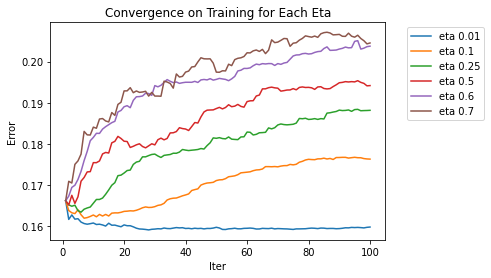

In [ ]:
# fixed number of rounds (increasing number of trees used)
nrounds = 100

# make col names
columns = []
for e in eta:
    columns.append('eta '+ str(e))

# create empty dfs to hold the convergence and prediction results for our search over eta
conv_eta = pd.DataFrame(np.nan, index=list(range(1, nrounds+1)), columns=columns)
pred_eta = pd.DataFrame(np.nan, index=list(range(1, valid_df.shape[0]+1)), columns=columns)

for i in range(len(eta)):
    
    # Make model with changing eta values keeping all else constant
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                n_estimators = nrounds,
                               learning_rate = eta[i],
                                colsample_bylevel = cs[default[1]],
                                max_depth = md[default[2]],
                                subsample = ss[default[3]],
                               n_jobs = -1) # use more processing power
    
    # create the trees
    clf_xgb.fit(X_train, 
            y_train, 
            verbose=False, 
            eval_metric='error', 
            eval_set=[(X_valid, y_valid)])
    
    # Add error and predictions to conv and pred dfs
    conv_eta.iloc[:,i] = clf_xgb.evals_result()['validation_0']['error']
    pred_eta.iloc[:,i] = clf_xgb.predict(X_valid)

conv_eta['iter'] = list(range(1,nrounds+1))
conv_eta_long = pd.melt(conv_eta, id_vars='iter', var_name='eta', value_name='error')

sns.lineplot(x='iter', y='error', hue='eta', data=conv_eta_long)
plt.title('Convergence on Training for Each Eta')
plt.ylabel('Error')
plt.xlabel('Iter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Tuning colsample_bylevel

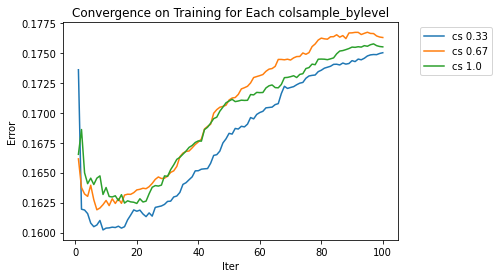

In [ ]:
# fixed number of rounds (increasing number of trees used)
nrounds = 100

# make col names
columns = []
for c in cs:
    columns.append('cs '+ str(c))

# create empty dfs to hold the convergence and prediction results for our search over cs
conv_cs = pd.DataFrame(np.nan, index=list(range(1, nrounds+1)), columns=columns)
pred_cs = pd.DataFrame(np.nan, index=list(range(1, valid_df.shape[0]+1)), columns=columns)

for i in range(len(cs)):    
    # Make model with changing cs values keeping all else constant
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                n_estimators = nrounds,
                               learning_rate = eta[default[0]],
                                colsample_bylevel = cs[i],
                                max_depth = md[default[2]],
                                subsample = ss[default[3]])
    # create the trees
    clf_xgb.fit(X_train, 
            y_train, 
            verbose=False, 
            eval_metric='error', 
            eval_set=[(X_valid, y_valid)])
    # Add error and predictions to conv and pred dfs
    conv_cs.iloc[:,i] = clf_xgb.evals_result()['validation_0']['error']
    pred_cs.iloc[:,i] = clf_xgb.predict(X_valid)

# add iter column and melt df
conv_cs['iter'] = list(range(1,nrounds+1))
conv_cs_long = pd.melt(conv_cs, id_vars='iter', var_name='cs', value_name='error')

# plot
sns.lineplot(x='iter', y='error', hue='cs', data=conv_cs_long)
plt.title('Convergence on Training for Each colsample_bylevel')
plt.ylabel('Error')
plt.xlabel('Iter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Tuning max_depth

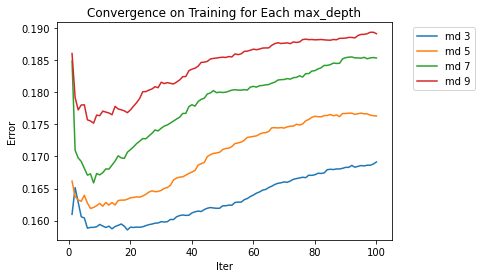

In [ ]:
# fixed number of rounds (increasing number of trees used)
nrounds = 100

# make col names
columns = []
for m in md:
    columns.append('md '+ str(m))

# create empty dfs to hold the convergence and prediction results for our search over md
conv_md = pd.DataFrame(np.nan, index=list(range(1, nrounds+1)), columns=columns)
pred_md = pd.DataFrame(np.nan, index=list(range(1, valid_df.shape[0]+1)), columns=columns)

for i in range(len(md)):    
    # Make model with changing md values keeping all else constant
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                n_estimators = nrounds,
                               learning_rate = eta[default[0]],
                                colsample_bylevel = cs[default[1]],
                                max_depth = md[i],
                                subsample = ss[default[3]])
    # create the trees
    clf_xgb.fit(X_train, 
            y_train, 
            verbose=False, 
            eval_metric='error', 
            eval_set=[(X_valid, y_valid)])
    # Add error and predictions to conv and pred dfs
    conv_md.iloc[:,i] = clf_xgb.evals_result()['validation_0']['error']
    pred_md.iloc[:,i] = clf_xgb.predict(X_valid)

# add iter column and melt df
conv_md['iter'] = list(range(1,nrounds+1))
conv_md_long = pd.melt(conv_md, id_vars='iter', var_name='md', value_name='error')

# plot
sns.lineplot(x='iter', y='error', hue='md', data=conv_md_long)
plt.title('Convergence on Training for Each max_depth')
plt.ylabel('Error')
plt.xlabel('Iter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Tuning Subsample

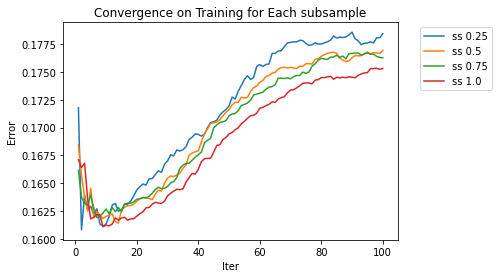

In [ ]:
# fixed number of rounds (increasing number of trees used)
nrounds = 100

# make col names
columns = []
for s in ss:
    columns.append('ss '+ str(s))

# create empty dfs to hold the convergence and prediction results for our search over ss
conv_ss = pd.DataFrame(np.nan, index=list(range(1, nrounds+1)), columns=columns)
pred_ss = pd.DataFrame(np.nan, index=list(range(1, valid_df.shape[0]+1)), columns=columns)

for i in range(len(ss)):    
    # Make model with changing cs values keeping all else constant
    clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                n_estimators = nrounds,
                               learning_rate = eta[default[0]],
                                colsample_bylevel = cs[default[1]],
                                max_depth = md[default[2]],
                                subsample = ss[i])
    # create the trees
    clf_xgb.fit(X_train, 
            y_train, 
            verbose=False, 
            eval_metric='error', 
            eval_set=[(X_valid, y_valid)])
    # Add error and predictions to conv and pred dfs
    conv_ss.iloc[:,i] = clf_xgb.evals_result()['validation_0']['error']
    pred_ss.iloc[:,i] = clf_xgb.predict(X_valid)

# add iter column and melt df
conv_ss['iter'] = list(range(1,nrounds+1))
conv_ss_long = pd.melt(conv_ss, id_vars='iter', var_name='ss', value_name='error')

# plot
sns.lineplot(x='iter', y='error', hue='ss', data=conv_ss_long)
plt.title('Convergence on Training for Each subsample')
plt.ylabel('Error')
plt.xlabel('Iter')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Train model with final parameters

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                            n_estimators = 20,
                            learn_rate = 0.01, 
                            max_depth = 3,
                            reg_lambda = 10, 
                            subsample = 1, 
                            colsample_bylevel = 0.33)

clf_xgb.fit(X_train, 
            y_train, 
            verbose=True,  
            eval_metric='auc',
            early_stopping_rounds = 10,
            eval_set=[(X_valid, y_valid)])

# make predictions on our test data
y_pred = clf_xgb.predict(X_valid)

# Confusion matrix
print(confusion_matrix(y_valid, y_pred))

# More classification metrics
print(classification_report(y_valid, y_pred))

# 0.791036 AUC

cm = confusion_matrix(y_valid, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FPR = FP[1]/(FP[1] + TN[0])
print('FPR: ', FPR)

accuracy = accuracy_score(y_valid, y_pred)
print('Accuracy: ', accuracy)

[0]	validation_0-auc:0.669931
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.729863
[2]	validation_0-auc:0.748066
[3]	validation_0-auc:0.752225
[4]	validation_0-auc:0.752633
[5]	validation_0-auc:0.758032
[6]	validation_0-auc:0.768323
[7]	validation_0-auc:0.774909
[8]	validation_0-auc:0.777306
[9]	validation_0-auc:0.781135
[10]	validation_0-auc:0.78097
[11]	validation_0-auc:0.780245
[12]	validation_0-auc:0.781305
[13]	validation_0-auc:0.783399
[14]	validation_0-auc:0.784069
[15]	validation_0-auc:0.78426
[16]	validation_0-auc:0.786514
[17]	validation_0-auc:0.788348
[18]	validation_0-auc:0.789069
[19]	validation_0-auc:0.791036
[[81263  1621]
 [14377  2739]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     82884
           1       0.63      0.16      0.26     17116

    accuracy                           0.84    100000
   macro avg       0.74      0.57      0.58    100000
weighted avg       0.81  

# Light GBM
Now we will try Light GBM, which is a gradient boosting framework that grows trees vertically (leaf-wise) rather than horizontally (level-wise).


LightGBM can handle larger data faster than other tree-based algorithms and uses less memory to run. It focuses on accuracy of results and supports GPU learning.

It is best to use LightGBM on data larger than 10k rows due to its sensitivity to overfitting.

Resources:<br>
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

### Option 1: using sklearn interface to train and predict model

In [ ]:
# Prelim LightGBM
lgb_clf = LGBMClassifier(random_state=45)

In [ ]:
%%time
lgb_clf.fit(X_train, y_train)

CPU times: user 2.82 s, sys: 10 ms, total: 2.83 s
Wall time: 2.85 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=45, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = lgb_clf.predict(X_valid)

# LightGBM accuracy score out of the box
accuracy_score(y_valid, y_pred)

0.82498

## LightGBM Hyperparameter Tuning

Below, I will attempt to tune the hyperparameters using multiple methods.

<u>First method</u>
- Perform grid search on small subset of parameters normally used for xgboost

<u>Second method</u>
- Perform grid search in 2 sections
- first half addressing model complexity (num_leaves, max_depth, and/or regularization)
- second half addressing convergence (learning rate, num of iterations)

<u>Third method</u>
- random grid search using lightGBM training API

<b>Grid Search using small subset of xgboost parameters</b>

In [ ]:
# Cross validation with 3 folds
folds = 3

# Instantiate LightGBM for classification
lgb_clf = lgb.LGBMClassifier(objective='binary', metric='auc')

# A parameter grid for XGBoost
gs_params = {
    'learning_rate': [.01, .05, .1],
    'boosting_type': ['gbdt'],
    'num_iterations': [500, 1000],
    'sub_feature': [1]
    }

# Prepare grid search
gridsearch = GridSearchCV(lgb_clf, param_grid=gs_params, scoring='roc_auc', n_jobs=4, verbose=2, cv = folds)

# Perform grid search
gridsearch.fit(X_train, y_train)

# results
print('All results: ', gridsearch.cv_results_)
print('Best estimator: ', gridsearch.best_estimator_)
print('Best Score: ', gridsearch.best_score_)
print('Best hyperparameters: ', gridsearch.best_params_)
gs_results = pd.DataFrame(gridsearch.cv_results_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  3.9min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


All results:  {'mean_fit_time': array([35.05988646, 59.81438565, 26.68647869, 49.71354604, 25.843268  ,
       41.05081693]), 'std_fit_time': array([0.87959658, 0.65368535, 0.41621968, 0.20338184, 1.29954285,
       0.21634474]), 'mean_score_time': array([ 8.24370249, 19.69976338,  5.83341487, 16.57219871,  4.25396101,
        9.1881849 ]), 'std_score_time': array([0.49186314, 0.3396961 , 0.58760503, 0.15277262, 0.75567016,
       1.78942206]), 'param_boosting_type': masked_array(data=['gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt', 'gbdt'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.05, 0.05, 0.1, 0.1],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_num_iterations': masked_array(data=[500, 1000, 500, 1000, 500, 1000],
             mask=[False, False, False, False, False, False],
       fill_value='?

In [ ]:
# Get Predictions for 1s
gs_probs = gridsearch.predict_proba(X_valid)[:,1]

# Convert probs to binary values
cutoff  = .5 
pred_list = []
for i in gs_probs:
    if i >= cutoff:
        prediction = 1
    else:
        prediction = 0
    pred_list.append(prediction)

y_pred = np.array(pred_list)

cm = confusion_matrix(y_valid, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FPR = FP[1]/(FP[1] + TN[0])
print('FPR: ', FPR)

accuracy = accuracy_score(y_valid, y_pred)
print('Accuracy: ', accuracy)

FPR:  0.49463786136151694
Accuracy:  0.83022


<b>Grid Search in 2 sections</b>

In [ ]:
# 1st Stage of Hyperparameter Tuning (for model complexity)
param_grid = {'num_leaves':[7, 15, 31, 63],
              'max_depth': [3, 4, 5, 6, -1]}

grid_search = GridSearchCV(estimator=lgb_clf, param_grid=param_grid, cv=5, verbose=1, n_jobs=4)

grid_search.fit(X_train, y_train)

# Best hyperparameters and accuracy score
print('Best Params: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

# Accuracy score after 1st stage of tuning
# print('Accuracy: ', accuracy_score(y_valid, grid_search.predict(X_valid)))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.2min finished


Best Params:  {'max_depth': 3, 'num_leaves': 7}
Best Score:  0.821792


In [ ]:
# 2nd Stage of Hyperparameter Tuning (for convergence)
num_iterations = 200
lgb_clf2 = LGBMClassifier(random_state=45, 
                          max_depth=3, 
                          num_leaves=7, 
                          n_estimators=num_iterations, 
                          n_jobs=1)

param_grid2 = {'learning_rate': np.logspace(-3, 0, 10)}

grid_search2 = GridSearchCV(estimator=lgb_clf2, param_grid=param_grid2, cv=5, verbose=1, n_jobs=4)

grid_search2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.4min finished


{'learning_rate': 0.001} 0.853556


In [24]:
final_lgb = LGBMClassifier(n_estimators=200, 
                           num_leaves=7, 
                           learning_rate=0.001, 
                           max_depth=3, 
                           n_jobs=4)

final_lgb.fit(X_train, y_train)

lgb_final_pred = final_lgb.predict(X_valid)
# cm = confusion_matrix(y_valid, lgb_final_pred)
# FP = cm.sum(axis=0) - np.diag(cm)
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = cm.sum() - (FP + FN + TP)
# FPR = FP[1]/(FP[1] + TN[0])
# print('FPR: ', FPR)

print('Accuracy: ', accuracy_score(y_valid, lgb_final_pred))
confusion_matrix(y_valid, lgb_final_pred)

FPR:  nan
Accuracy:  0.82884


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


array([[82884,     0],
       [17116,     0]])

If you lower the learning rate and increase the number of iterations, you'll have better convergence and thus higher accuracy. If you set a super high number of iterations with super low learning rate, convergence will be perfect.

You set the number of iterations as high as you can afford it (can do 1000-3000)

<b>Random grid search using LightGBM training API</b>

Rather than using sklearn's interface to train and predict, we're using the api directly and also must convert output from predictions to binary values.

In [26]:
# First convert training data into LightGBM dataset format (required for LightGBM training)
d_train = lgb.Dataset(X_train, label=y_train)

Random Grid Search

In [ ]:
# %%time
# # keep track of the iteration on random grid search
# count = 0
# # starting accuracy
# best_accuracy = 0

# # Perform 50 random grid searches and train model to find model with best accuracy
# iterations = 50
# for i in range(iterations):
#   print('iteration number', count)
#   count += 1 # increment count
#   params = {} # initialize parameters
#   params['learning_rate'] = np.random.uniform(0, 1)
#   params['boosting_type'] = 'gbdt'
#   params['objective'] = 'binary'
#   params['metric'] = 'binary_logloss'
#   params['sub_feature'] = np.random.uniform(0, 1)
#   params['num_leaves'] = np.random.randint(20, 300)
#   params['min_data'] = np.random.randint(10, 100)
#   params['max_depth'] = np.random.randint(5, 200)
#   iterations = np.random.randint(10, 10000)

#   # Train using selected parameters
#   clf = lgb.train(params, d_train, iterations)

#   # Predictions on validation set
#   y_pred = clf.predict(X_valid)

#   # Convert predictions to binary values
#   for i in range(0, len(y_valid)):
#     if y_pred[i] >= 0.5:
#       y_pred[i] = 1
#     else:
#       y_pred[i] = 0

#   accuracy = accuracy_score(y_valid, y_pred)
#   print('Accuracy: ', accuracy)
#   if accuracy > best_accuracy:
#     best_accuracy = accuracy
#     best_params = params

# print('Best Accuracy: ', best_accuracy)
# print('Best Params: ', best_params)


"""Best Accuracy:  0.83027
Best Params:  {'learning_rate': 0.633930150861436, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'sub_feature': 0.47941330449217057, 'num_leaves': 238, 'min_data': 12, 'max_depth': 64}
CPU times: user 3h 44min 53s, sys: 17min 49s, total: 4h 2min 43s
Wall time: 2h 11min 44s"""

"Best Accuracy:  0.83027\nBest Params:  {'learning_rate': 0.633930150861436, 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'binary_logloss', 'sub_feature': 0.47941330449217057, 'num_leaves': 238, 'min_data': 12, 'max_depth': 64}\nCPU times: user 3h 44min 53s, sys: 17min 49s, total: 4h 2min 43s\nWall time: 2h 11min 44s"

### Below are the results from the random grid search.

Accuracy: 0.83027

Params:
- learning_rate =  0.633930150861436
- boosting_type = 'gbdt'
- objective = 'binary' 
- metric = 'binary_logloss'
- sub_feature = 0.47941330449217057
- num_leaves = 238
- min_data = 12
- max_depth = 64

CPU times: user 3h 44min 53s, sys: 17min 49s, total: 4h 2min 43s
Wall time: 2h 11min 44s.

In [25]:
best_params = {'learning_rate': 0.633930150861436, 
               'boosting_type': 'gbdt', 
               'objective': 'binary', 
               'metric': 'binary_logloss', 
               'sub_feature': 0.47941330449217057, 
               'num_leaves': 238, 
               'min_data': 12, 
               'max_depth': 64}

In [28]:
# Get final model using best parameters with previous number of iterations (570)
final_lgb = lgb.train(best_params, d_train, 570)

# Get predictions on validation data
y_pred = final_lgb.predict(X_valid)

# Convert predictions to binary values
for i in range(0, len(y_valid)):
  if y_pred[i] >= 0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

accuracy_score(y_valid, y_pred)

0.73565

In [29]:
final_lgb = LGBMClassifier(n_estimators=200, 
                           num_leaves=238, 
                           max_depth=64,
                           sub_feature=0.47941330449217057,
                           learning_rate=0.633930150861436,
                           min_data=12,
                           n_jobs=4)

final_lgb.fit(X_train, y_train)
y_pred = final_lgb.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.75842